In [2]:
import pandas as pd
import seaborn as sns


In [2]:
!git clone https://github.com/kanekomasahiro/gp_debias
!cd ./gp_debias; mkdir d; cd d; git clone https://github.com/uclanlp/gn_glove.git
!paste ./gp_debias/d/gn_glove/wordlist/female_word_file.txt ./gp_debias/d/gn_glove/wordlist/male_word_file.txt > ./gp_debias/wordlist/gender_pair.tsv 
!cp -r ./gp_debias/d/gn_glove/SemBias ./gp_debias/
!ls ./gp_debias

Cloning into 'gn_glove'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 199 (delta 2), reused 6 (delta 2), pack-reused 193
Receiving objects: 100% (199/199), 67.78 KiB | 207.00 KiB/s, done.
Resolving deltas: 100% (88/88), done.
d	     eval_word_embeddings.py  LICENSE	 run.sh   src
download.sh  hyperparams	      README.md  SemBias  wordlist


In [9]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
from numpy import dot
from numpy.linalg import norm
from gensim.models import KeyedVectors
import argparse
from scipy import stats
from functools import reduce

SEM_BIAS = './SemBias/SemBias'
GP_GN = '/media/pavel/tmp/glove/gp_gn.txt'
GN_GLOVE = '/media/pavel/tmp/glove/vectors300.txt'
GLOVE = '/media/pavel/tmp/glove/vectors.txt'
GOOGLE_ANT = '/media/pavel/tmp/glove/google_anthology_ds.txt'
RG65 = '/media/pavel/tmp/glove/RG65.csv'
WS = '/media/pavel/tmp/glove/WordSim353.csv'
MTURK = '/media/pavel/tmp/glove/MTurk.csv'
RW = '/media/pavel/tmp/glove/RW2034.csv'
MEN = '/media/pavel/tmp/glove/MEN3000.csv'
SIMLEX = '/media/pavel/tmp/glove/SimLex-999.txt'
SEM_EVAL = '/media/pavel/tmp/glove/SemEval'
GP_GLOVE = '/media/pavel/tmp/glove/gp_glove.txt'
STEREOTYPE = '/media/pavel/tmp/WS/nlp_proj/gp_debias/wordlist/stereotype_list.tsv'
NOGENDER = '/media/pavel/tmp/WS/nlp_proj/gp_debias/wordlist/no_gender_list.tsv'
GENDER = '/media/pavel/tmp/WS/nlp_proj/gp_debias/wordlist/gender_pair.tsv'


In [4]:
def load_words_pair(words, embedding, gender_v, w1, w2, categ):
    """put cosine similarity and category for pair of words into word dictionary"""
    v1 = embedding[w1]
    v2 = embedding[w2]
    score1 = dot(gender_v, v1)/(norm(gender_v)*norm(v1))
    score2 = dot(gender_v, v2)/(norm(gender_v)*norm(v2))
    words[w1] = (score1, categ)
    words[w2] = (score2, categ)
    return


def evaluate_embeding_accuracies(model, emb_name, file=SEM_BIAS):
    """
       compute embeding prediction accuracies for gender relational analogies
       on SemBias dataset and SemBias-subset
       #######################################################################
       This code is taken from supplimentary materials to the following paper for evaluation:
       Masahiro Kaneko, Danushka Bollegala "Gender-preserving Debiasing for Pre-trained Word Embeddings", 
       2019
       https://github.com/kanekomasahiro/gp_debias
       #######################################################################
    """
    definition_num = 0
    none_num = 0
    stereotype_num = 0
    total_num = 0
    sub_definition_num = 0
    sub_none_num = 0
    sub_stereotype_num = 0
    sub_size = 40
    words, uni_words = {}, []

    # updated code to close file
    with open(file) as bias_analogy_f:
        sub_start = -(sub_size - sum(1 for line in bias_analogy_f))
    # updated code to close file later
    bias_analogy_f = open(file)

    gender_v = model['he'] - model['she']
    for sub_idx, l in enumerate(bias_analogy_f):
        l = l.strip().split()
        max_score = -100
        for i, word_pair in enumerate(l):
            word_pair = word_pair.split(':')
            pre_v = model[word_pair[0]] - model[word_pair[1]]
            score = dot(gender_v, pre_v)/(norm(gender_v)*norm(pre_v))
            if score > max_score:
                max_idx = i
                max_score = score
            # updated code to return full vocabulary as uni_words
            if word_pair[0] not in uni_words:
                uni_words.append(word_pair[0])
            if word_pair[1] not in uni_words:
                uni_words.append(word_pair[1])
            # updated code to return similarities and type of words pair as dict words
            load_words_pair(words, model, gender_v, word_pair[0], word_pair[1], i)
        if max_idx == 0:
            definition_num += 1
            if sub_idx >= sub_start:
                sub_definition_num += 1
        elif max_idx == 1 or max_idx == 2:
            none_num += 1
            if sub_idx >= sub_start:
                sub_none_num += 1
        elif max_idx == 3:
            stereotype_num += 1
            if sub_idx >= sub_start:
                sub_stereotype_num += 1
        total_num += 1
    if definition_num == 0:
        print('definition: 0')
    else:
        print('definition: {}'.format(definition_num / total_num))
    if stereotype_num == 0:
        print('stereotype: 0')
    else:
        print('stereotype: {}'.format(stereotype_num / total_num))
    if none_num == 0:
        print('none: 0')
    else:
        print('none: {}'.format(none_num / total_num))
    if sub_definition_num == 0:
        print('sub definition: 0')
    else:
        print('sub definition: {:.5f}'.format(sub_definition_num / sub_size))
    if sub_stereotype_num == 0:
        print('sub stereotype: 0')
    else:
        print('substereotype: {:.5f}'.format(sub_stereotype_num / sub_size))
    if sub_none_num == 0:
        print('sub none: 0')
    else:
        print('sub none: {:.5f}'.format(sub_none_num / sub_size))
    # updated code to close file
    bias_analogy_f.close()
    # updated code to save results to text-file for table
    with open(f'{emb_name}_results.txt', 'w') as f:
        f.write(f'{definition_num / total_num}, {stereotype_num / total_num}, {none_num / total_num}, ' +
                f'{sub_definition_num / sub_size}, {sub_stereotype_num / sub_size}, {sub_none_num / sub_size}\n')
    return uni_words, words


def load_wordlist(fname):
    with open(fname, 'r') as f:
        lst = [w.replace('\n', '').strip() for w in f]
    return lst


def load_gender_pairs(fname):
    with open(fname, 'r') as f:
        replaced = [w.replace('\n', '') for w in f]
        lst = [w.split() for w in replaced if w.split()[0] not in ['sororal', 'barwoman', 'brideprice', 'airwomen'] ]
    return list(reduce(lambda x, y: x + y, lst))


In [5]:
def similarity(gender_v, v):
    return dot(gender_v, v)/(norm(gender_v) * norm(v))


def print_neutral_stereotype_similarities(emb, uni, words):
    """print neutral, stereotype and gender words similarities mean and std"""
    gender_v = emb['he'] - emb['she']
    
    stereotype = load_gender_pairs(STEREOTYPE)
    neutral = load_wordlist(NOGENDER)
    gender =  [s for s in uni if words[s][1] in [1, 2]]
    
    neutral_sims = np.array([similarity(gender_v, emb[w]) for w in neutral])
    stereot_sims = np.array([similarity(gender_v, emb[w]) for w in stereotype])
    gender_sims = np.array([similarity(gender_v, emb[w]) for w in gender])
    templ1, templ2 = 'Mean, std for ', ' words similarities with gender_v are:'
    
    print(f'{templ1}neutral{templ2}{neutral_sims.mean()}{neutral_sims.std()}\n' +
          f'{templ1}stereotype{templ2}{stereot_sims.mean()} {stereot_sims.std()}\n' + 
          f'{templ1}gender{templ2}{gender_sims.mean()} {gender_sims.std()}')
    del neutral_sims, stereot_sims, gender_sims 
    return

    
def plot_graphs(emb, uni, words, embeddings_type):
    """ draw scatter plot of words similarities with gender vector gender_v VS word number """
    from sklearn.manifold import TSNE
    w = words
    gender_def = ['he', 'she', 'gentleman', 'lady', 'businesswoman', 'businessman',  'spokesman', 'spokeswoman', 
                  'congresswoman', 'congressman', 'waiter', 'waitress', 'policewoman', 'policeman']
    gender_v = emb['he'] - emb['she']

    st_lst = load_gender_pairs(STEREOTYPE)
    stereotype = sorted(st_lst)[:50]
    nt_lst = load_wordlist(NOGENDER)
    neutral = sorted(nt_lst)[:50]

    n_len = len(neutral)
    all_words = neutral + gender_def + stereotype
    
    y = np.array([similarity(gender_v, v) for v in [emb[s] for s in all_words]])
    X = np.array(list(range(len(all_words))))
    colors = [0.7 if i < n_len else 2.3 if i < n_len + len(gender_def) else 1.4 for i in range(len(all_words))]
    #plot 2D T-SNE grapth for word vectors
    tsne = TSNE(random_state=17)
    X_tsne = tsne.fit_transform([emb[w] for w in all_words])
    
    plt.figure(figsize=(12,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, vmin=0, vmax=3,
                edgecolor='none', s=60,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.title(f't-SNE projection for {embeddings_type} vectors for {len(all_words)} words');
    plt.show()
    # Gender related cosine similarities for embedding
    plt.figure(figsize=(12,10))
    plt.scatter(y, X, c=colors, vmin=0, vmax=3,
                edgecolor='none',  s=70,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.ylabel("number in word list")
    plt.xlabel("similarity")
    plt.savefig(f'{embeddings_type}_sim.jpg', bbox_inches='tight')
    plt.show()
    return


In [6]:
def get_GENERIC_DS(fn, emb):
    """ load text dataset"""
    with open(fn, "r") as f:
        v = [line.lower().split() for line in f]
    return [similarity(emb[p[0]], emb[p[1]]) for p in v], [p[2] for p in v]


def get_RW(fn, emb, vocab):
    """ load RW dataset"""
    def get_score(p1, p2):
        return similarity(emb[p1], emb[p2]) if p1 in vocab and p2 in vocab else 0.
    
    
    with open(fn, "r") as f:
        v = [[line[:10].strip()] + list(line.lower().split()) for line in f]
    return [get_score(p[0], p[1].strip()) for p in v], [p[2].strip() for p in v]


def get_MEN(fn, emb):
    """ to load MEN dataset"""
    with open(fn, "r") as f:
        v = [line.lower().split() for line in f]
    return [similarity(emb[p[0].split('-')[0]], emb[p[1].split('-')[0]]) for p in v], [p[2] for p in v]


def get_WordSim(fn, emb):
    """ to load WORDSIM dataset"""
    with open(fn, "r") as f:
        v = [line.lower().split() for line in f if line[:6] != "Word 1"]
    return [similarity(emb[p[0]], emb[p[1]]) for p in v], [p[2] for p in v]


def get_SimLex(fn, emb):
    """ to load SIMLEX dataset"""
    with open(fn, "r") as f:
        v = [line.lower().split() for line in f if line[:5] != "word1"]
    return [similarity(emb[p[0]], emb[p[1]]) if p[0] != 'disorganize' else 0 for p in v], [p[3] for p in v]


def compute_correlation_bewteen_embedding_results_and_ratings(emb, vocab, emb_name):
    """
       compute cosine similrity for words pairs from RG65, WordSim Orig, WordSim Balanced, MTurk, RW,
       MEN and SimLex datasets. 
       Then compute correlation bewteen already calculated similarities and human ratings
    """
    similarity1, scores = get_GENERIC_DS(RG65, emb)
    similarity3, scores3 = get_WordSim(WS, emb)
    similarity4, scores4 = get_GENERIC_DS(MTURK, emb)
    similarity5, scores5 = get_RW(RW, emb, vocab)
    similarity6, scores6 = get_GENERIC_DS(MEN, emb)
    similarity7, scores7 = get_SimLex(SIMLEX, emb)
    # compute correlation bewteen calculated similarities and human ratings
    sr = stats.spearmanr(np.array(similarity1), np.array(scores))
    print(f'Spearman rank correlation on RG65: {sr.correlation}')
    sr_ws2 = stats.spearmanr(np.array(similarity3), np.array(scores3))
    print(f'Spearman rank correlation on WS: {sr_ws2.correlation}')
    sr_turk = stats.spearmanr(np.array(similarity4), np.array(scores4))
    print(f'Spearman rank correlation on TURK: {sr_turk.correlation}')
    sr_rw = stats.spearmanr(np.array(similarity5), np.array(scores5))
    print(f'Spearman rank correlation on RW: {sr_rw.correlation}')
    sr_men = stats.spearmanr(np.array(similarity6), np.array(scores6))
    print(f'Spearman rank correlation on MEN: {sr_men.correlation}')
    sr_simlex = stats.spearmanr(np.array(similarity7), np.array(scores7))
    print(f'Spearman rank correlation on SimLex: {sr_simlex.correlation}')
    # save results to a file
    with open(f'{emb_name}_sp_correlations.txt' ,'w') as f:
        f.write(f'{sr.correlation}, {sr_ws2.correlation}, {sr_turk.correlation}, {sr_rw.correlation}, \
        {sr_men.correlation}, {sr_simlex.correlation}\n')
    return


def get_vocabulary(fname):
    """ load vocabulary """
    with open(fname, "r") as f:
        vocab = [line.lower().split()[0] for line in f]
    # skip the first line which contains word count and number of components in embedding
    return vocab[1:]

# uni, w = evaluate_embeding_accuracies(emb_glove, emb_type)

In [10]:
def calculate_results(path, emb_type):
    """
        Calculating embeding accuracies, spearman correlations_bewteen word pairs similarities and ratings
        and drawing Graph with cosine similarities between gender vector and representations 
        for stereotypes, gender-definitional and neutral words.
    """
    # load Embedding and vocabulary
    emb_gn = KeyedVectors.load_word2vec_format(path, binary=False)
    vocab = get_vocabulary(path)
    
    print(f'Evaluating bias using SemEval dataset for {emb_type} representation')
    uni, words_dict = evaluate_embeding_accuracies(emb_gn, emb_type)
    compute_correlation_bewteen_embedding_results_and_ratings(emb_gn, vocab, emb_type)
    
    print_neutral_stereotype_similarities(emb_gn, uni, words_dict)
    print(f'Draw Scatter Plots with gender related cosine similarities for {emb_type}')
    plot_graphs(emb_gn, uni, words_dict, emb_type)

    # cleaning up memory
    del emb_gn, vocab
    return



\begin{align*}
sum i,j (a+b)^2 = a^2+2ab+b^2
\end{align*}

Evaluating bias using SemEval dataset for GloVe representation
definition: 0.8022727272727272
stereotype: 0.10909090909090909
none: 0.08863636363636364
sub definition: 0.57500
substereotype: 0.20000
sub none: 0.22500
Spearman rank correlation on RG65: 0.746880260363494
Spearman rank correlation on WS: 0.599652147475783
Spearman rank correlation on TURK: 0.6489883631126866
Spearman rank correlation on RW: 0.7480827682977469
Spearman rank correlation on MEN: 0.24401717123636338
Spearman rank correlation on SimLex: 0.3485738190977309
Mean, std for neutral words similarities with gender_v are:-0.00025087653193622830.058663226664066315
Mean, std for stereotype words similarities with gender_v are:-0.026481281965970993 0.10634755343198776
Mean, std for gender words similarities with gender_v are:-0.022217780351638794 0.07693222165107727
Draw Scatter Plots with gender related cosine similarities for GloVe


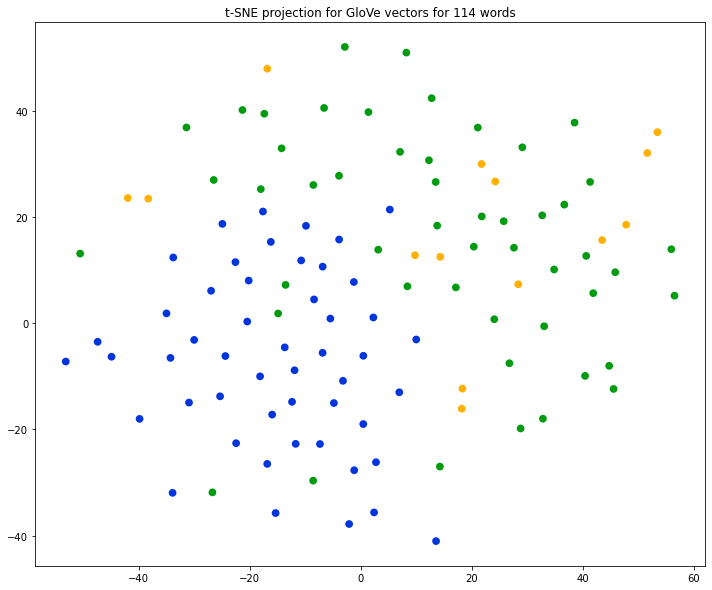

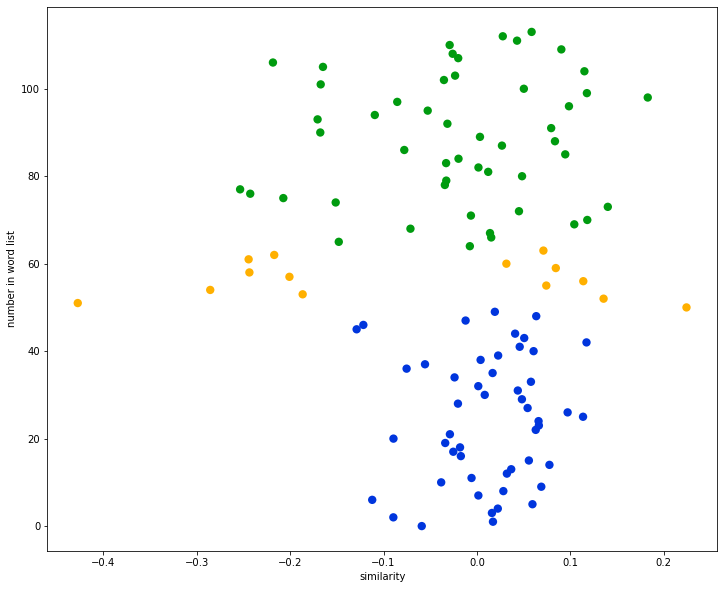

In [11]:
calculate_results(GLOVE, 'GloVe')

Evaluating bias using SemEval dataset for GN-GloVe representation
definition: 0.9772727272727273
stereotype: 0.013636363636363636
none: 0.00909090909090909
sub definition: 0.75000
substereotype: 0.15000
sub none: 0.10000
Spearman rank correlation on RG65: 0.7323688194598698
Spearman rank correlation on WS: 0.6131594848679267
Spearman rank correlation on TURK: 0.6621889181411698
Spearman rank correlation on RW: 0.7432692685873683
Spearman rank correlation on MEN: 0.26638565854070917
Spearman rank correlation on SimLex: 0.37145936650008704
Mean, std for neutral words similarities with gender_v are:-0.0072272676043212410.03980892896652222
Mean, std for stereotype words similarities with gender_v are:-0.015346067026257515 0.09649530053138733
Mean, std for gender words similarities with gender_v are:-0.023990267887711525 0.04670482873916626
Draw Scatter Plots with gender related cosine similarities for GN-GloVe


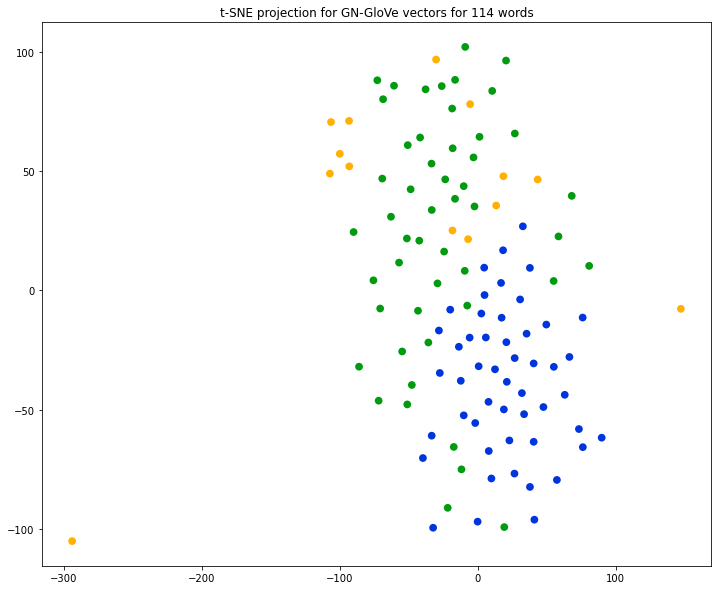

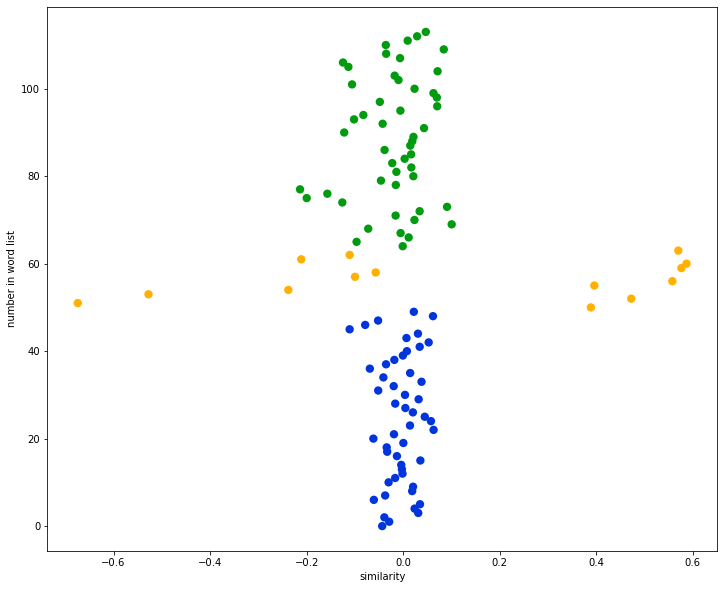

In [12]:
calculate_results(GN_GLOVE, 'GN-GloVe')

Evaluating bias using SemEval dataset for GP-GloVe representation
definition: 0.8386363636363636
stereotype: 0.08181818181818182
none: 0.07954545454545454
sub definition: 0.62500
substereotype: 0.15000
sub none: 0.22500
Spearman rank correlation on RG65: 0.7571956219696847
Spearman rank correlation on WS: 0.5839478318763939
Spearman rank correlation on TURK: 0.6423386777768434
Spearman rank correlation on RW: 0.7456860028109273
Spearman rank correlation on MEN: 0.22897346870784524
Spearman rank correlation on SimLex: 0.3425400754986843
Mean, std for neutral words similarities with gender_v are:-0.0015120845055207610.0646001398563385
Mean, std for stereotype words similarities with gender_v are:-0.017214147374033928 0.10047338157892227
Mean, std for gender words similarities with gender_v are:-0.008122685365378857 0.07896425575017929
Draw Scatter Plots with gender related cosine similarities for GP-GloVe


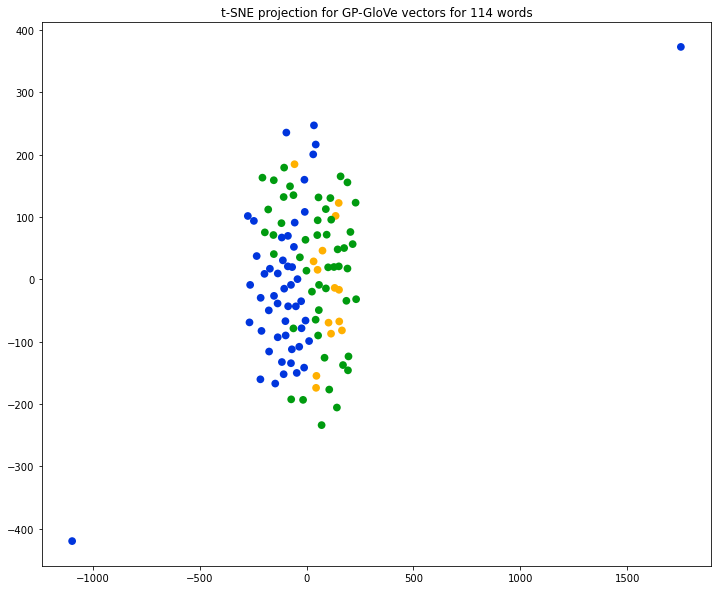

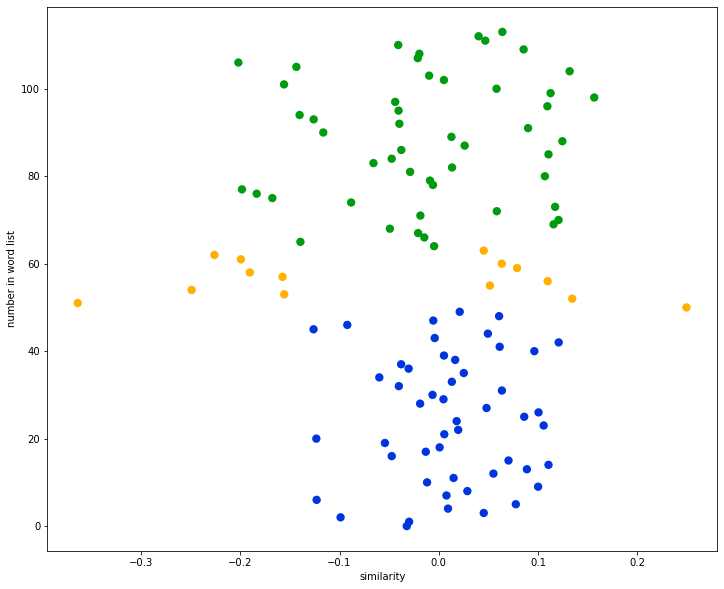

In [13]:
calculate_results(GP_GLOVE, 'GP-GloVe')

Evaluating bias using SemEval dataset for GP-GN-GloVe representation
definition: 0.9840909090909091
stereotype: 0.011363636363636364
none: 0.004545454545454545
sub definition: 0.82500
substereotype: 0.12500
sub none: 0.05000
Spearman rank correlation on RG65: 0.7187315617432108
Spearman rank correlation on WS: 0.6246082976030765
Spearman rank correlation on TURK: 0.6786980298465641
Spearman rank correlation on RW: 0.7404598064780832
Spearman rank correlation on MEN: 0.26744775834720397
Spearman rank correlation on SimLex: 0.38675684605130156
Mean, std for neutral words similarities with gender_v are:-0.017553009092807770.03700370341539383
Mean, std for stereotype words similarities with gender_v are:-0.013937083072960377 0.09273838251829147
Mean, std for gender words similarities with gender_v are:-0.0206748154014349 0.038857825100421906
Draw Scatter Plots with gender related cosine similarities for GP-GN-GloVe


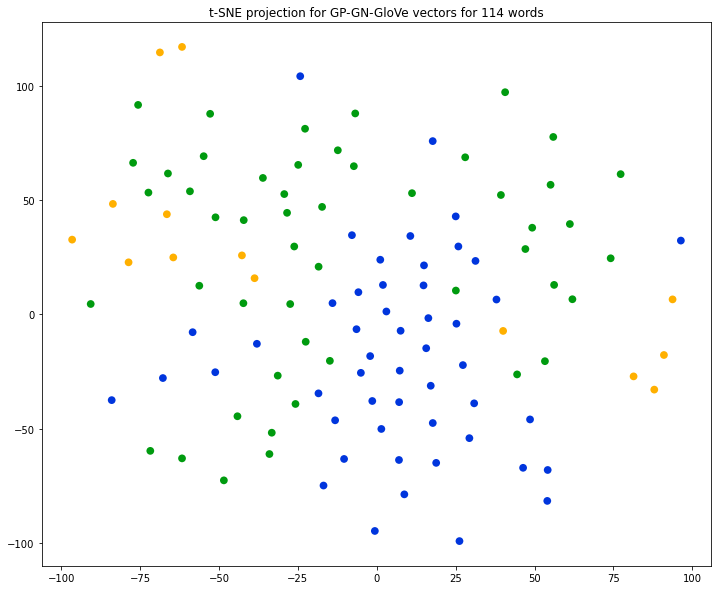

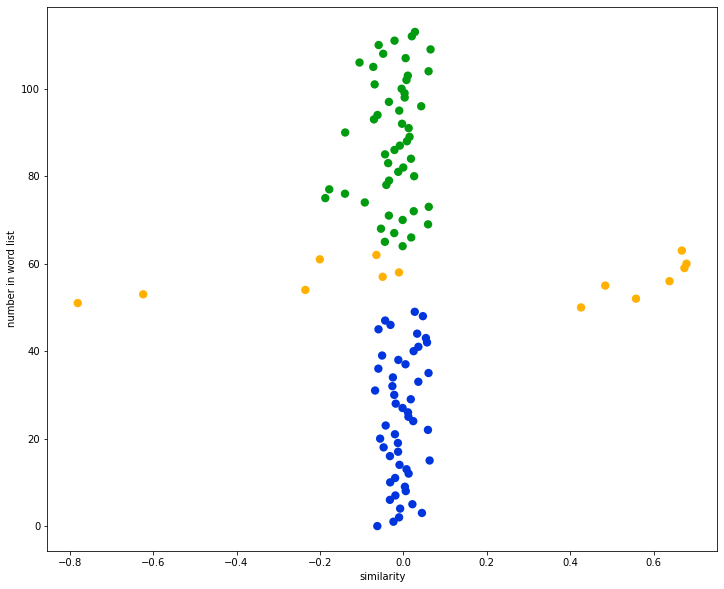

In [14]:
calculate_results(GP_GN, 'GP-GN-GloVe')